In [15]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("when_approach").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

DataFrame[]

In [16]:
from pyspark.sql.functions import lit,col
import pandas as pd
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from CreateDataset import get_features_all_stocks_seq, get_tabular_dataset, get_feature_col_names, get_not_null_cols
from pyspark.ml.feature import StandardScaler
from pyspark.sql.window import Window

In [17]:
def split_train_test(df, split_date):
    split_date = pd.to_datetime(split_date)
    train_df = df.filter(col('date')<split_date)
    test_df = df.filter(col('date')>=split_date)
    return train_df, test_df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

def scale(train_df, test_df):
#     train_df = train_df.withColumn('year', F.year('date'))
#     test_df = test_df.withColumn('year', F.year('date'))
#     window_spec = Window().partitionBy('year')

#     feature_cols = train_df.columns[2:-1]

#     scaling_params = {}

#     for c in feature_cols:
#         mean_col = F.avg(F.col(c)).over(window_spec)
#         stddev_col = F.stddev(F.col(c)).over(window_spec)
#         epsilon = 1e-10

#         # Calculate mean and standard deviation for each year
#         train_means = train_df.select('year', mean_col.alias(c + '_mean')).distinct()
#         train_stddevs = train_df.select('year', stddev_col.alias(c + '_stddev')).distinct()

#         # Join means and stddevs back to the main dataframe
#         train_df = train_df.join(train_means, on='year', how='left').join(train_stddevs, on='year', how='left')

#         # Scale the column using the calculated mean and stddev
#         train_df = train_df.withColumn(c, (F.col(c) - F.col(c + '_mean')) / (F.col(c + '_stddev') + epsilon))

#         # Save scaling parameters
#         scaling_params[c] = {'mean_col': c + '_mean', 'stddev_col': c + '_stddev'}

#     for c, params in scaling_params.items():
#         # Scale the test set using the mean and stddev from the training set
#         test_df = test_df.withColumn(c, (F.col(c) - F.lit(params['mean_col'])) / F.lit(params['stddev_col']) + epsilon)

    return train_df, test_df


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

    

In [18]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


In [19]:
df = get_df()

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


['ff_assets_gr', 'ff_net_inc_per_emp', 'ff_debt_entrpr_val', 'ff_fcf_yld', 'ff_sga_oth', 'ff_gross_cf_debt', 'ff_dil_adj', 'ff_shs_float', 'ff_xord', 'ff_inc_sund', 'ff_net_inc_basic_beft_xord', 'ff_non_oper_exp', 'ff_cf_ps_gr', 'ff_emp_gr', 'ff_net_inc_bef_xord_gr', 'ff_com_eq_gr', 'ff_mkt_val_gr', 'ff_zscore', 'ff_dfd_tax_assets_lt', 'ff_ut_non_oper_inc_oth', 'ff_mkt_val_public', 'ff_xord_disc', 'ff_bps_gr', 'ff_ut_operation_exp', 'ff_sales_fix_assets', 'CPI', 'ff_bk_non_oper_inc', 'ff_capex_assets']


+--------+----------+-----------------+-------------------+------------------+----------+----------+-----------------+----------+---------------+-------+-----------+--------------------------+-------------------+------------------+-----------------+----------------------+-----------------+-------------+---------+--------------------+----------------------+-----------------+------------+-----------------+-------------------+-------------------+------------+------------------+-----------------+
| fsym_id|      date|     ff_assets_gr| ff_net_inc_per_emp|ff_debt_entrpr_val|ff_fcf_yld|ff_sga_oth| ff_gross_cf_debt|ff_dil_adj|   ff_shs_float|ff_xord|ff_inc_sund|ff_net_inc_basic_beft_xord|    ff_non_oper_exp|       ff_cf_ps_gr|        ff_emp_gr|ff_net_inc_bef_xord_gr|     ff_com_eq_gr|ff_mkt_val_gr|ff_zscore|ff_dfd_tax_assets_lt|ff_ut_non_oper_inc_oth|ff_mkt_val_public|ff_xord_disc|        ff_bps_gr|ff_ut_operation_exp|ff_sales_fix_assets|         CPI|ff_bk_non_oper_inc|  ff_capex_assets|
+---

114986


114986


Number of rows:  111210


Number of positives:  579


Number of rows after dropping nulls:  111210


Number of positives after dropping nulls:  579


In [6]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, test_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_test = test_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features


# train_df, test_df = get_df(all_feats=True)
# boruta_features = boruta_fs(train_df, test_df, 'rf')
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [8]:
train_df = train_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot' )
test_df = test_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot' )



NameError: name 'train_df' is not defined

In [20]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')

In [22]:
feats = df.columns[2:-1]
# write_features_file(feats)
feats

['ff_assets_gr',
 'ff_net_inc_per_emp',
 'ff_debt_entrpr_val',
 'ff_fcf_yld',
 'ff_sga_oth',
 'ff_gross_cf_debt',
 'ff_dil_adj',
 'ff_shs_float',
 'ff_xord',
 'ff_inc_sund',
 'ff_net_inc_basic_beft_xord',
 'ff_non_oper_exp',
 'ff_cf_ps_gr',
 'ff_emp_gr',
 'ff_net_inc_bef_xord_gr',
 'ff_com_eq_gr',
 'ff_mkt_val_gr',
 'ff_zscore',
 'ff_dfd_tax_assets_lt',
 'ff_ut_non_oper_inc_oth',
 'ff_mkt_val_public',
 'ff_xord_disc',
 'ff_bps_gr',
 'ff_ut_operation_exp',
 'ff_sales_fix_assets',
 'CPI',
 'ff_bk_non_oper_inc',
 'ff_capex_assets']

In [46]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline
# from pyspark.ml.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
# from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

def confusion_matrix_pandas(acts, preds):
    cm = confusion_matrix(acts, preds) #correct order
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

        
def feature_importances(model, features):
    feature_importances = model.feature_importances_

    print("Feature Importances:")
    for feature, importance in zip(features, feature_importances):
        print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()

        
def model_testing(df, classifier):
    df = df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'date', 'label']
    
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0)
        }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict)
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    else:
        raise ValueError("Unsupported classifier")
    tscv = TimeSeriesSplit(n_splits=5)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        else:
            return params
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        return score
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=5)
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        classifier_instance.fit(x_train, Y_train)
        # train_preds = pd.DataFrame()
        # train_preds['prediction'] = classifier_instance.predict(X_train)
        # train_preds['label'] = y_train
        # print(f"TRAIN AND TEST FOR {classifier}")
        # confusion_matrix_pandas(train_preds)
        test_preds = pd.DataFrame()
        preds = classifier_instance.predict(x_test)
        test_preds['prediction'] = preds
        test_preds['label'] = Y_test
        print(f"Classification Report for Fold {i}:")
        print(classification_report(Y_test, preds))
        i+=1
        cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        
#     if classifier != 'LogisticRegression':
#         feature_importances(classifier_instance, X_train.columns.tolist())
        
#     return classifier_instance, X_train.columns.tolist(), X_train, X_test
#     shapley(classifier_instance, X_train.columns.tolist(), X_train)
        
        

model_testing(df, 'RandomForest')
# basic_test(train_df, test_df)

Converted to Pandas
100%|██████████| 5/5 [17:26<00:00, 209.29s/trial, best loss: -0.28635829438209714]
Classification Report for Fold 0:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18440
           1       0.27      0.24      0.25        95

    accuracy                           0.99     18535
   macro avg       0.63      0.62      0.63     18535
weighted avg       0.99      0.99      0.99     18535



NameError: name 'classifer_instance' is not defined

In [ ]:
def shapley(model, features, X_train, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    print(shap_values.shape)
    shap.summary_plot(shap_values, X_test)
    # shap.plots.waterfall(shap_values)
    # shap.plots.bar(shap_values)
    # shap.summary_plot(shap_values[0], X_test)
    # shap.summary_plot(shap_values[1], X_test)

# shapley(model, feats, X_train, X_test)

Epoch 1/50
580/580 [==============================] - 2s 2ms/step - loss: 0.4932 - accuracy: 0.8372
Epoch 2/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4363 - accuracy: 0.8561
Epoch 3/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4179 - accuracy: 0.8522
Epoch 4/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4007 - accuracy: 0.8479
Epoch 5/50
580/580 [==============================] - 1s 2ms/step - loss: 0.3959 - accuracy: 0.8552
Epoch 6/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4012 - accuracy: 0.8492
Epoch 7/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4213 - accuracy: 0.8581
Epoch 8/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4171 - accuracy: 0.8473
Epoch 9/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4348 - accuracy: 0.8609
Epoch 10/50
580/580 [==============================] - 1s 2ms/step - loss: 0.4128 - accuracy: 0.8571

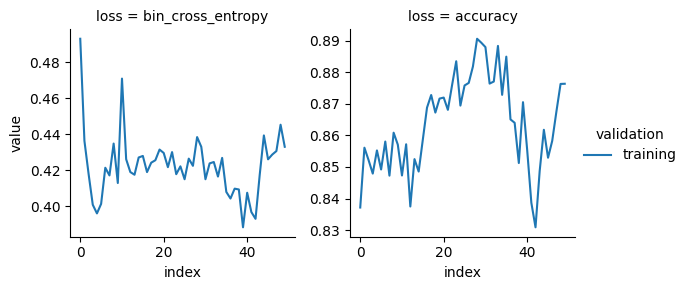

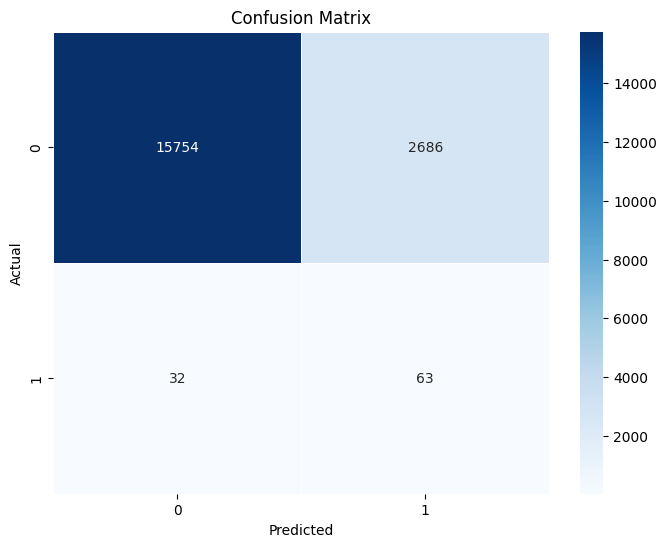

Epoch 1/50
1159/1159 [==============================] - 3s 2ms/step - loss: 0.4913 - accuracy: 0.8552
Epoch 2/50
1159/1159 [==============================] - 3s 2ms/step - loss: 0.4669 - accuracy: 0.8591
Epoch 3/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4602 - accuracy: 0.8631
Epoch 4/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4392 - accuracy: 0.8638
Epoch 5/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4662 - accuracy: 0.8361
Epoch 6/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4752 - accuracy: 0.8245
Epoch 7/50
1159/1159 [==============================] - 3s 2ms/step - loss: 0.4639 - accuracy: 0.8262
Epoch 8/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4748 - accuracy: 0.8607
Epoch 9/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.4793 - accuracy: 0.8535
Epoch 10/50
1159/1159 [==============================] - 2s 2ms/step - loss: 0.468

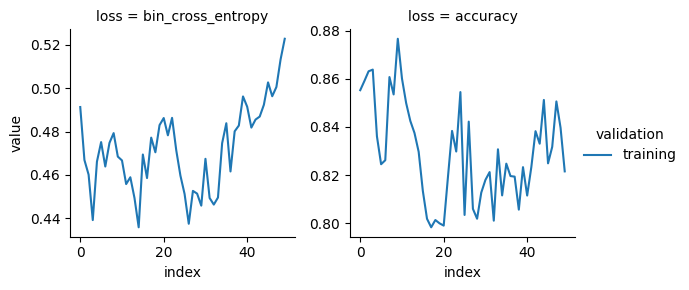

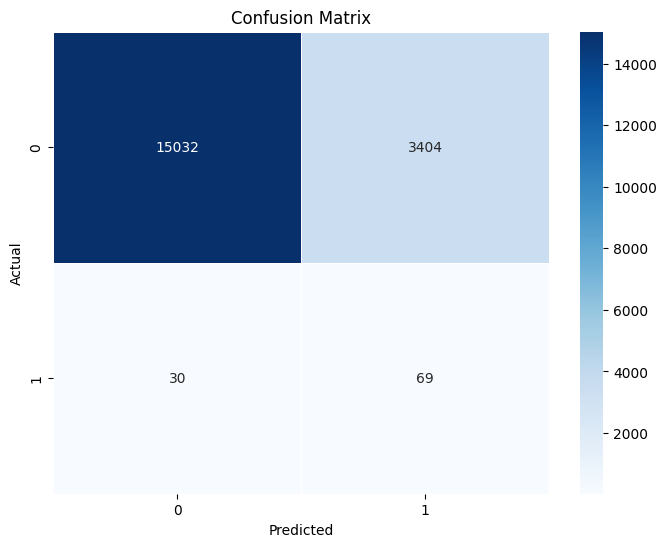

Epoch 1/50
1738/1738 [==============================] - 3s 2ms/step - loss: 0.5387 - accuracy: 0.8205
Epoch 2/50
1738/1738 [==============================] - 3s 2ms/step - loss: 0.5309 - accuracy: 0.8228
Epoch 3/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.5216 - accuracy: 0.8184
Epoch 4/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.4988 - accuracy: 0.8160
Epoch 5/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.4991 - accuracy: 0.8293
Epoch 6/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.4972 - accuracy: 0.8171
Epoch 7/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.5128 - accuracy: 0.8202
Epoch 8/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.5071 - accuracy: 0.8369
Epoch 9/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.5164 - accuracy: 0.8366
Epoch 10/50
1738/1738 [==============================] - 4s 2ms/step - loss: 0.513

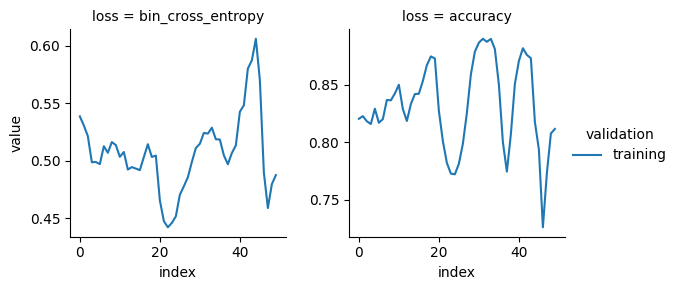

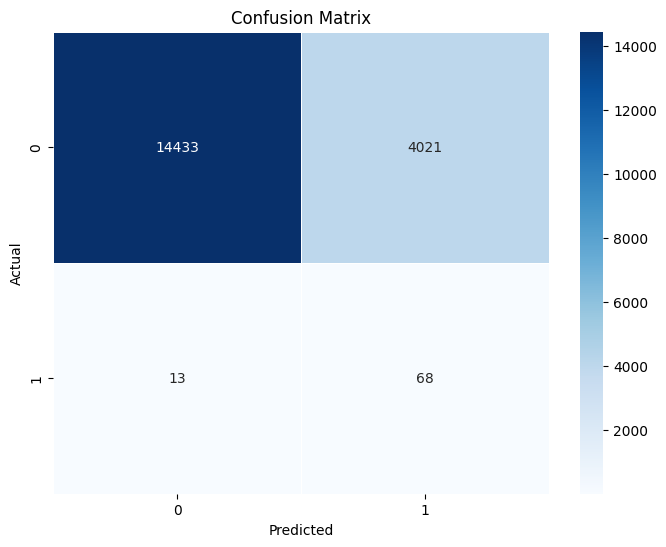

Epoch 1/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4749 - accuracy: 0.8200
Epoch 2/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4855 - accuracy: 0.8215
Epoch 3/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4656 - accuracy: 0.8527
Epoch 4/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4579 - accuracy: 0.7874
Epoch 5/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4646 - accuracy: 0.7921
Epoch 6/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4711 - accuracy: 0.8299
Epoch 7/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4706 - accuracy: 0.8503
Epoch 8/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.4921 - accuracy: 0.8400
Epoch 9/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.5053 - accuracy: 0.8630
Epoch 10/50
2317/2317 [==============================] - 5s 2ms/step - loss: 0.516

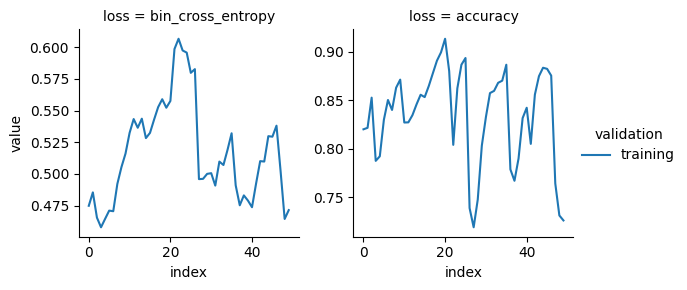

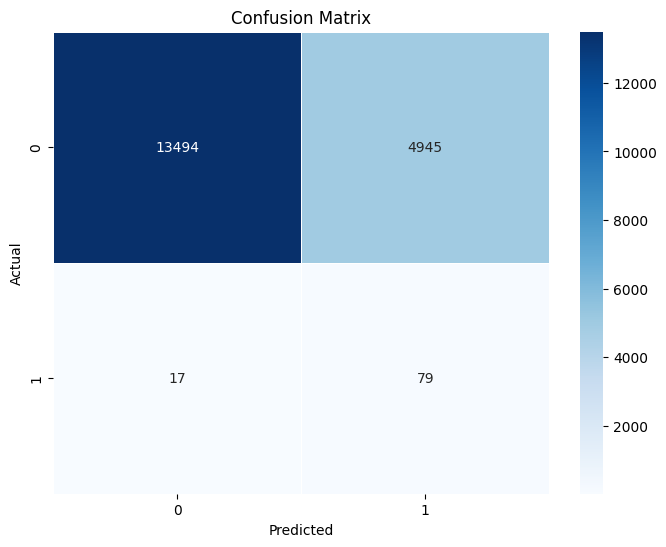

Epoch 1/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4868 - accuracy: 0.7613
Epoch 2/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4935 - accuracy: 0.7984
Epoch 3/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4924 - accuracy: 0.8194
Epoch 4/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4686 - accuracy: 0.7890
Epoch 5/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4732 - accuracy: 0.7711
Epoch 6/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4780 - accuracy: 0.7581
Epoch 7/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.4945 - accuracy: 0.7782
Epoch 8/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.5042 - accuracy: 0.7945
Epoch 9/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.5034 - accuracy: 0.8115
Epoch 10/50
2897/2897 [==============================] - 6s 2ms/step - loss: 0.499

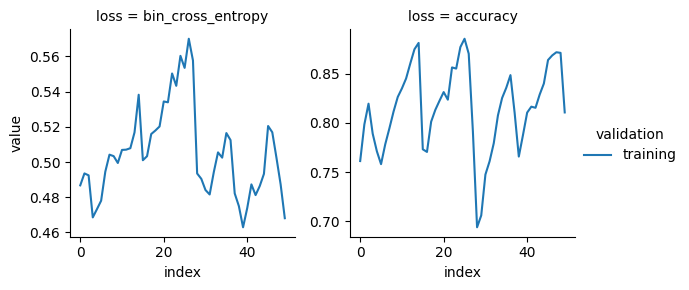

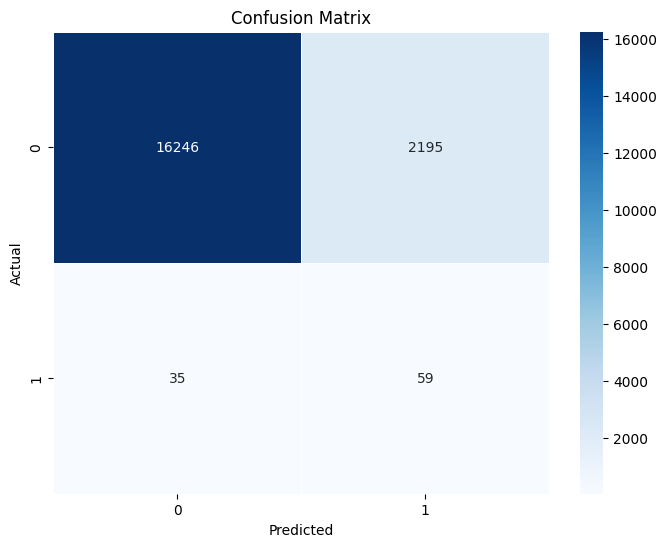

In [45]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight



def prepare_seqs(df):
    train_df = df.toPandas()
    # val_split_date = pd.to_datetime('2017-01-01')
    # val_df = train_df[train_df['date'] >= val_split_date]
    # print(len(val_df)/len(train_df))
    # print(len(val_df[val_df['label']==1]))
    # train_df = train_df[train_df['date'] < val_split_date]
    # test_df = test_df.toPandas()
    feature_cols = train_df.columns[2:-1]
    # nn_train_feats = train_df[feature_cols].values
    # nn_train_labels = train_df['label'].values
    # nn_test_feats = test_df[feature_cols].values
    # nn_test_labels = test_df['label'].values
    # nn_val_feats = val_df[feature_cols].values
    # nn_val_labels = val_df['label'].values
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="tanh"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.005
    )
    
    def plot_model_performance(mdl, loss, metric):
        x = pd.DataFrame(mdl.history).reset_index()
        x = pd.melt(x, id_vars='index')
        x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
        x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
        g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
        g.map(sns.lineplot, 'index','value')
        g.add_legend()
        return g
    
    # space = {
    # 'units1': hp.choice('units1', np.arange(8, 64, dtype=int)),
    # 'units2': hp.choice('units2', np.arange(8, 64, dtype=int)),
    # 'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1))
    # }
#     def objective(params):
#         model = keras.Sequential([
#             keras.layers.Dense(params['units1'], activation="tanh"),
#             keras.layers.Dense(params['units2'], activation="relu"),
#             keras.layers.Dense(1, activation="sigmoid")
#         ])
#         model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

#         # Train and evaluate the model using cross-validation
#         scores = cross_val_score(model, nn_train_feats, nn_train_labels, cv=tscv, scoring='f1')
#         mean_f1 = -np.mean(scores)  # Negate to maximize F1 score
#         return mean_f1
    
#     best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)
#     best_units1 = np.arange(8, 64, dtype=int)[best_params['units1']]
#     best_units2 = np.arange(8, 64, dtype=int)[best_params['units2']]
#     best_learning_rate = best_params['learning_rate']
#     final_model = keras.Sequential([
#         keras.layers.Dense(best_units1, activation="tanh"),
#         keras.layers.Dense(best_units2, activation="relu"),
#         keras.layers.Dense(1, activation="sigmoid")])
    model.compile(optimizer=optimizer,
                        loss=loss_fn,
                        metrics=['accuracy'])

    # final_model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict)
    
    i=1
    for train_idx, val_idx in tscv.split(train_df):
        train_fold = train_df.iloc[train_idx, :]
        val_fold = train_df.iloc[val_idx, :]
        nn_train_feats = train_fold[feature_cols].values
        nn_train_labels = train_fold['label'].values
        nn_val_feats = val_fold[feature_cols].values
        nn_val_labels = val_fold['label'].values
        class_weights = compute_class_weight('balanced', classes=np.unique(nn_train_labels), y=nn_train_labels)
        class_weight_dict = dict(enumerate(class_weights))
        fit_model = model.fit(nn_train_feats, nn_train_labels, epochs=50, batch_size=32, class_weight=class_weight_dict)

        plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(nn_val_feats, nn_val_labels)
        print(f'Test accuracy: {test_acc}')

        # Make predictions on new data
        predictions = model.predict(nn_val_feats)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(f"Classification Report for Fold {i}:")
        print(classification_report(nn_val_labels, predictions))
        i+=1
        print(np.sum(nn_val_labels==1))
        print(np.sum(predictions==1))
        cm = confusion_matrix(nn_val_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# prepare_seqs(df)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

def cross_val(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    classifiers = [lr, rf, gb]
    
    cv_models = []
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    for classifier in classifiers:
        print("Starting...")
        pipeline = Pipeline(stages=[assembler, classifier])
        
        paramGrid = ParamGridBuilder() \
        .addGrid(classifier.regParam, [0.01, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
        .addGrid(classifier.maxIter, [10, 20]) \
        .build()
        
        cross_val = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=5
        )
        
        cv_model = cross_val.fit(train_df)
        cv_models.append(cv_model)
        print("Working")
    
    for cv_model in cv_models:
        predictions = cv_model.transform(test_df)
        auc = evaluator.evaluate(predictions)
        print(f"Model AUC: {auc}")
        
def basic_test(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    lr = lr.fit(train_df)
    preds_train_df = lr.transform(train_df)
    preds_test_df = lr.transform(test_df)
    
    
def cross_val_pandas(train_df, test_df):
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'date', 'label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'max_iter': [100, 200, 300]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        },
        'SVM': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf']
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='roc_auc')

        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_

        predictions = best_model.predict(X_test)

        auc = roc_auc_score(y_test, predictions)

        print(f"\nResults for {model_name}:")
        print(f"Area under the ROC curve (AUC): {auc}")
        print("Best model hyperparameters:")
        print(grid_search.best_params_)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        

#model_testing(train_df, test_df)
#cross_val_pandas(train_df, test_df)

In [ ]:
# spark.stop()